# GCC's ssc-cdi : ptychography pipeline for Cateretê v0.7.15
 
- #### Questions? E-mail gcc@lnls.br

## Imports

In [ ]:
%matplotlib widget
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from jupyterlab_h5web import H5Web
import sscInstall
import sscCdi
import sscResolution

print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscResolution version: {sscResolution.__version__}')

## Inputs

In [ ]:
input_dict = {
    
'beamline': 'CAT',
'detector': '540D',
'debug': False, # use False

"data_folder": "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/",
"acquisition_folders": ["SS03112022_02"],
"projections": [0],

"flatfield": "",
 
# "mult_obj_probe" is a dictionary with tags for use initial objects and probe from previous ptycho. 
# "run_again" should be True for running ptycho one more time with previous object and/or probe.
# "mult_obj" equals True uses the previous object
# "mult_probe" equals True uses previous probe
# One can combine using probe and object setting both True    
    
"mult_obj_probe": {"run_again" : False,
                   "mult_obj"  : False,
                   "mult_probe": False}, 

'CPUs': 32,
'GPUs': [0],

'binning': 1, 
'using_direct_beam': False, # if True, converts DP_center coordinates from raw to restored coordinates
'DP_center': [1392,1405],  # [center_y, center_x]
'fill_blanks': False, # interpolate blank lines after restoration
'keep_original_negative_values': False, 
'suspect_border_pixels': 3, # pixels
'detector_ROI_radius': 300, # pixels

'position_rotation': -0.003, # radians. angle between detector and probe coordinate system

'object_padding': 50, # pixels

'incoherent_modes': 0, 
'probe_support': [ "circular", 300,0,0 ], # ["circular",radius_pxls,center_y, center_x]; (0,0) is the center of the image
'fresnel_number': -0.001,

"initial_obj": ["random"], # path to .npy, .hdf5, ["random"], ["constant"]
"initial_probe": ["inverse"], # path to .npy, .hdf5, ["inverse"], ["random"], ["constant"], ["circular",radius]

'Algorithm1': {'Batch': 64,
                'Beta': 0.995,
                'Epsilon': 0.01,
                'Iterations': 70,
                'Name': 'RAAR',
                'ProbeCycles': 4,
                'TV': 0},

# 'Algorithm2': {'Batch': 64,
#                 'Epsilon': 0.01,
#                 'Iterations': 50,
#                 'Name': 'GL',
#                 'ObjBeta': 0.97,
#                 'ProbeBeta': 0.95,
#                 'TV': 0.0001},

'Algorithm2': {'Batch': 64,
                'Epsilon': 0.01,
                'Iterations': 50,
                'Name': 'positioncorrection',
                'ObjBeta': 0.97,
                'ProbeBeta': 0.95,
                'TV': 0.0001},
    
'Algorithm3': {'Batch': 64,
                'Epsilon': 0.1,
                'Iterations': 5,
                'Name': 'GL',
                'ObjBeta': 0.5,
                'ProbeBeta': 0.5,
                'TV': 0.01},

# 'Algorithm4': { 'Name': 'PIE',
#                 'Iterations': 100,
#                 'step_obj': 0.5,    # step size for object update
#                 'step_probe': 1,    # step size for probe update
#                 'reg_obj': 0.25,    # regularization for object update
#                 'reg_probe': 0.5,   # regularization for probe update
#                 'Batch':1}, 

}

input_dict = sscCdi.caterete.cat_ptycho_processing.define_paths(input_dict)

## Load diffraction data to find center

In [3]:
# path = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/SS03112022_02/scans/0000_SS03112022_02_001.hdf5" # enter path to raw diffractiom dataset

# fig, ax = plt.subplots(dpi=100)
# ax.imshow(np.squeeze(h5py.File(path,'r')['entry/data/data'])[0],norm=LogNorm(),cmap='jet')

# Run Locally

In [4]:
json_filepath_path = sscCdi.beamlines.caterete.cat_ptycho_processing.save_input_dictionary(input_dict)

## Restoration

In [5]:
restoration_dict_list, restored_data_info_list, filepaths, filenames, folder_names, folder_numbers = sscCdi.beamlines.caterete.cat_restoration.restoration_ptycho_CAT(input_dict) # restoration of all frames; restored DPs saved at temporary folder

	Using 1 of 3 angle(s)


h5clear error: h5tools_fopen


## Ptychography

In [6]:
input_dict, obj, probe, probe_positions = sscCdi.beamlines.caterete.cat_ptycho_processing.cat_ptychography(input_dict,restoration_dict_list,restored_data_info_list,filepaths,filenames,folder_names,folder_numbers) # corrected_positions is an empty list if corrected position algorithm is not used
obj, probe, angles, positions, error = sscCdi.misc.save_volume_from_parts(input_dict)


Reading diffraction data for angle: 0
	Finished reading diffraction data! DPs shape: (625, 600, 600)
Reading probe positions...
	Object pixel size = 87.67 nm
	Limit thickness for resolution of 1 pixel: 243.880 microns
	Finished reading probe positions. Shape: (625, 2)
	Initial object shape: (1, 969, 974)	 Initial probe shape: (1, 1, 600, 600)
	Estimated size for 1 DPs of type float32: 0.90 GBs
Fresnel number: -0.001
Creating initial probe...
	Probe shape (600,600) with 1 incoherent mode(s)
Setting probe support...
Creating initial object...
Diffraction Patterns: (625, 600, 600)
Initial Object: (969, 974)
Initial Probe: (1, 600, 600)
Probe Support: (1, 600, 600)
Probe Positions: (625, 4)
Creating datapack...
Total datapack size: 0.92 GBs
Starting ptychography... using 1 GPUs [0] and 32 CPUs
	Calling 70 iterations of RAAR algorithm...
	Done in: 10.32 seconds
	Calling 50 iterations of GL algorithm...
	Done in: 6.51 seconds
	Calling 5 iterations of GL algorithm...
	Done in: 0.66 seconds
C

In [7]:
if 1: # phase
    preview = np.angle(obj)
else: # magnitude
    preview = np.abs(obj)

# sscCdi.misc.visualize_magnitude_and_phase(obj)
sscCdi.misc.deploy_visualizer(preview,title='Sinogram',cmap='gray')

## Crop object

In [8]:
input_dict['crop'] = [330,620,300,600]
cropped_object = sscCdi.beamlines.caterete.cat_ptycho_processing.crop_sinogram(input_dict,obj,probe_positions)
if 1: # phase
    cropped_object = np.angle(cropped_object)
else: # magnitude
    cropped_object = np.abs(cropped_object)

In [9]:
sscCdi.misc.deploy_visualizer(cropped_object,title='Cropped sinogram',cmap='gray')

## Unwrap object

In [11]:
phase = sscCdi.processing.unwrap.unwrap_in_parallel(cropped_object)
sscCdi.misc.save_variable(input_dict,phase, name = 'object_unwrapped')

Using 32 parallel processes


100%|██████████| 1/1 [00:00<00:00, 33.48it/s]


In [12]:
sscCdi.misc.deploy_visualizer(phase,title='Unwrapped',cmap='gray')

## Equalize 2D

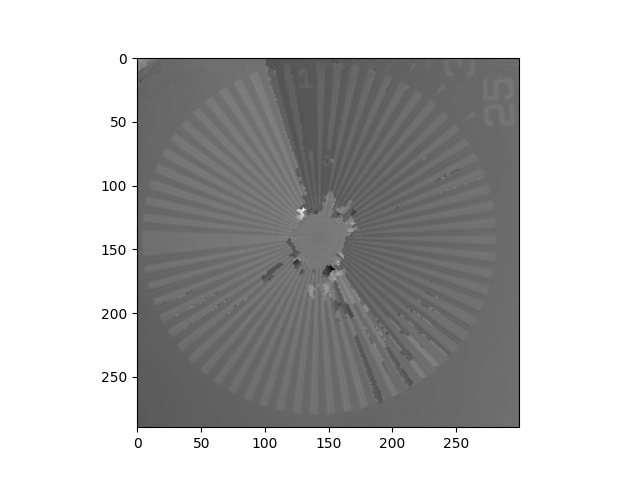

In [14]:
dic = {}
dic["equalize_invert"] = True # invert phase shift signal from negative to positive
dic["equalize_ROI"] = [] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = True  # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_local_offset"] = False # remove offset of each frame from the mean of ROI 
dic["equalize_set_min_max"]= [] # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = False # turn any remaining negative values to zero

frame = phase[0] # make sure to select a 2D frame
equalized_frame = sscCdi.tomo_processing.equalize_frame(dic,frame)

figure, ax = plt.subplots(dpi=100)
ax.imshow(equalized_frame,cmap='gray')

## Fourier Ring Correlation

In [15]:
frame = 0

if 1: # FRC on phase image
    img = phase[frame]
else: # else, on absorption image
    img = np.abs(cropped_object)[frame]

padding = 0
sharpness = 10
radius = 0.8

dic = sscResolution.frc.computep( sscResolution.frc.window( img, padding, [sharpness, radius] ) , input_dict["CPUs"] ) 
print(f"\tResolution via halfbit criterion: {1e9*input_dict['object_pixel']/dic['x']['H']:.2f} nm")

sscResolution.frc.plot(dic, {'label': "Resolution", 'unit': "nm", 'pxlsize': input_dict['object_pixel']*1e9} )

ValueError: operands could not be broadcast together with shapes (290,300) (290,290) 